# Проект для «Викишоп»

**Заказчик:** интернет-магазин «Викишоп» 

**Описание:** компания запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию

**Задача:** необходимо создать модель классифиции комментариев на позитивные и негативные. Предоставлены данные с разметкой о токсичности правок

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from tqdm import tqdm, notebook
from tqdm.notebook import tqdm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score, precision_recall_curve, roc_auc_score, f1_score  

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=['Unnamed: 0'])
data.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [7]:
data.info()
# пропусков нет, тип данных верный

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
data.describe()
# аномалии отсутствуют

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
print("Количество дубликатов:", data.duplicated().sum())

Количество дубликатов: 0


Количество отрицательных коментариев (1) и положительных (0)
    toxic
0  143106
1   16186

 Процент отрицательных коментариев (1) и положительных (0)
       toxic
0  89.838787
1  10.161213


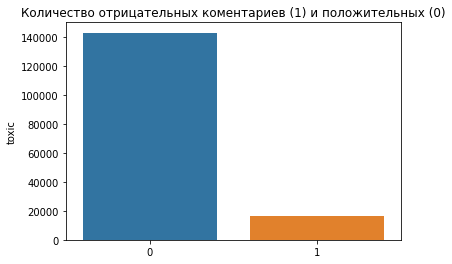

In [10]:
print('Количество отрицательных коментариев (1) и положительных (0)')
print(data['toxic'].value_counts().to_frame())
print('\n','Процент отрицательных коментариев (1) и положительных (0)')
print((data['toxic'].value_counts(normalize=True)*100).to_frame())


sns.barplot(data=data, x= data['toxic'].unique(),y=data['toxic'].value_counts()).set(title='Количество отрицательных коментариев (1) и положительных (0)');

Таким образом, наблюдается дисбаланс классов, с которым мы будем работать далее

In [11]:
lemmatizer = WordNetLemmatizer()

corpus = list(data['text'])

In [12]:
# функция по очистке данных
def clear_text(text):
    y = re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k = " ".join(y.split()).lower()
    return k

In [13]:
# функция, лемматизиующая каждое слово

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [14]:
# проверим работу функции
test = "cats don't eat apples"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(test)])

['cat', 'do', "n't", 'eat', 'apple']


In [15]:
# функция для лемматизации
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 


In [16]:
%%time
tqdm.pandas()

data['lemm_text'] = data['text'].progress_apply(clear_text)
data['lemm_text'] = data['lemm_text'].progress_apply(lemmafunction)

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 19min 10s, sys: 1min 18s, total: 20min 29s
Wall time: 20min 51s


In [17]:
data['text'][13]

"Before you start throwing accusations and warnings at me, lets review the edit itself-making ad hominem attacks isn't going to strengthen your argument, it will merely make it look like you are abusing your power as an admin. \nNow, the edit itself is relevant-this is probably the single most talked about event int he news as of late. His absence is notable, since he is the only living ex-president who did not attend. That's certainly more notable than his dedicating an aircracft carrier. \nI intend to revert this edit, in hopes of attracting the attention of an admin that is willing to look at the issue itself, and not throw accusations around quite so liberally. Perhaps, if you achieve a level of civility where you can do this, we can have a rational discussion on the topic and resolve the matter peacefully."

In [18]:
data['lemm_text'][13]

"before you start throw accusation and warning at me let review the edit itself make ad hominem attack be n't go to strengthen your argument it will merely make it look like you be abuse your power a an admin now the edit itself be relevant this be probably the single most talk about event int he news a of late his absence be notable since he be the only living ex president who do not attend that 's certainly more notable than his dedicate an aircracft carrier i intend to revert this edit in hope of attract the attention of an admin that be willing to look at the issue itself and not throw accusation around quite so liberally perhaps if you achieve a level of civility where you can do this we can have a rational discussion on the topic and resolve the matter peacefully"

In [20]:
data.head()

,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits make under my username hardcore metallica fan be revert they be n't vandalism just closure on some gas after i vote at new york doll fac and please do n't remove the template from the talk page since i 'm retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d'aww he match this background colour i 'm seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i 'm really not try to edit war it 's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i ca n't make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it 's list in the relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page that 's on


In [ ]:
# определяем целевые показатели и обучающие
features = data['lemm_text']
target = data['toxic']

In [ ]:
# делим данные на тестовые и обучающие

x_train, x_other, y_train, y_other = train_test_split(
    features, target, test_size=0.2, random_state=12345, shuffle=True,stratify = target) 

x_test, x_valid, y_test, y_valid = train_test_split(
    x_other, y_other, test_size=0.5, random_state=12345, shuffle=True, stratify = y_other)


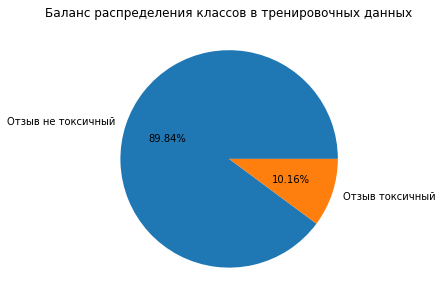

In [ ]:
# значение доли целевого показателя в обучающей выборке такое же как в полных данных
y_train.value_counts(normalize=True).plot(
    kind="pie",
    figsize=[5, 5],
    legend=False,
    autopct="%1.2f%%",
    labels=["Отзыв не токсичный", "Отзыв токсичный"],
)
plt.title("Баланс распределения классов в тренировочных данных")
plt.ylabel("")
plt.show()


In [ ]:
# для уравновешивания классов применим методы upsample и downsample, создадав функцию и перемешав результаты
def upsample(features, target, fraction, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones] * repeat
    )
    target_sampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones] * repeat
    )

    features_sampled, target_sampled = shuffle(
        features_sampled, target_sampled, random_state=12345
    )

    return features_sampled, target_sampled


# применение функции
features_sampled, target_sampled = upsample(x_train, y_train, 0.5, 5)


In [ ]:
print("Размер features_sampled", features_sampled.shape)
print("Размер target_sampled", target_sampled.shape)

Размер features_sampled (121987,)
Размер target_sampled (121987,)


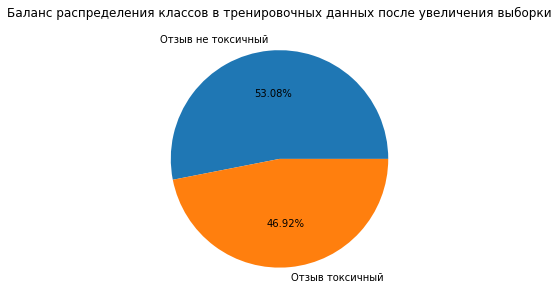

In [ ]:
# проверяем баланс классов после применения функции
target_sampled.value_counts(normalize=True).plot(kind='pie',figsize=[5,5], legend=False, autopct='%1.2f%%',labels=['Отзыв не токсичный','Отзыв токсичный'])
plt.title('Баланс распределения классов в тренировочных данных после увеличения выборки')
plt.ylabel('')
plt.show()

In [ ]:
# очищаем от стоп-слов
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords,analyzer='word')

x_train_sw = count_tf_idf.fit_transform(features_sampled)
x_valid_sw = count_tf_idf.transform(x_valid)
x_test_sw = count_tf_idf.transform(x_test)

In [ ]:
print('FEATURES SHAPE:')
print('X_TRAIN_SW', x_train_sw.shape)
print('X_VALID_SW', x_valid_sw.shape)
print('X_TEST_SW', x_test_sw.shape)
print()
print('TARGET SHAPE:')
print('TARGET_SAMPLED', target_sampled.shape)
print('Y_VALID', y_valid.shape)
print('Y_TEST', y_test.shape)

FEATURES SHAPE:
X_TRAIN_SW (121987, 91587)
X_VALID_SW (15930, 91587)
X_TEST_SW (15929, 91587)

TARGET SHAPE:
TARGET_SAMPLED (121987,)
Y_VALID (15930,)
Y_TEST (15929,)


Вывод:

Таким образом, дисбаланс классов был устранен, данные были лематизированы и очищены от стоп-слов и других лишних символов.

Приступим к применению моделей обучения.

## Обучение

### DecisionTreeClassifier

In [ ]:
%%time

best_model_dtc = None
best_result_dtc = 0
best_depth_dtc = 0
predict_dtc_best = []
for depth in tqdm(range(1, 25, 3)):
      
    model_dtc = DecisionTreeClassifier (random_state=12345, max_depth=depth, class_weight='balanced') 
    model_dtc.fit(x_train_sw,target_sampled) 
    predict_dtc = model_dtc.predict(x_valid_sw) 
    result_dtc = f1_score(y_valid, predict_dtc)
    if result_dtc > best_result_dtc:
        best_model_dtc = model_dtc
        best_result_dtc = result_dtc 
        predict_dtc_best = predict_dtc  
        best_depth_dtc = depth
print('\n',"F1 наилучшей модели равно:", best_result_dtc, end='')
print(' C глубиной:',best_depth_dtc)


  0%|          | 0/8 [00:00<?, ?it/s]


 F1 наилучшей модели равно: 0.6170212765957448 C глубиной: 22
CPU times: user 40.7 s, sys: 59.8 ms, total: 40.7 s
Wall time: 40.6 s


In [ ]:
# функция для иллюстрации значений целевого показателя и предсказания
def graph_analis(true, predict, model):
    f1 = f1_score(true, predict)
    plt.figure(figsize=(10,6))
    true.plot(kind='kde', linewidth=2)
    pd.Series(predict).plot(kind='kde',linewidth=2)
    plt.title('График распределения плотности предсказанных и целевых значений '+ model, y=1.01)
    plt.legend(['Целевые значения','Предсказанные значения'])
    plt.text(0.75,6,'F1= {:.2f}'.format(f1))
    plt.xlabel('')
    plt.grid()
    plt.ylabel('Плотность')
    plt.show()

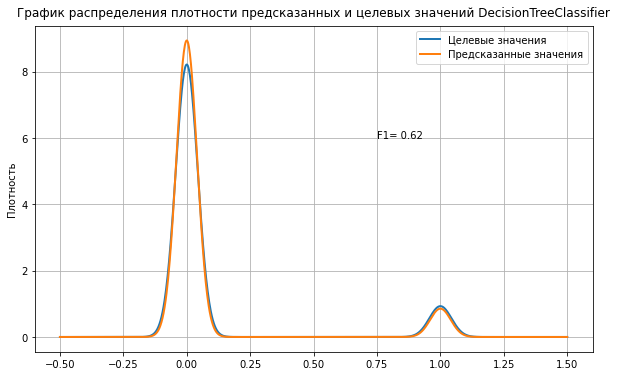

In [ ]:
graph_analis(y_valid, predict_dtc_best,'DecisionTreeClassifier')

### RandomForestClassifier

In [ ]:
%%time

best_model_rfc = None
best_result_rfc = 0
best_depth_rfc=0
best_prediction = []
for est in tqdm(range(1, 15, 5)):
      
    model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est,class_weight='balanced_subsample') 
    model_rfc.fit(x_train_sw,target_sampled) 
    predict_rfc = model_rfc.predict(x_valid_sw) 
    result_rfc = f1_score(y_valid, predict_rfc)
    if result_rfc > best_result_rfc:
        best_model_rfc = model_rfc
        best_result_rfc = result_rfc
        best_depth_rfc = est
        best_prediction = predict_rfc

print('\n', "F1 наилучшей модели равно:", best_result_rfc, end='')
print(' C глубиной:',best_depth_rfc)

  0%|          | 0/3 [00:00<?, ?it/s]


 F1 наилучшей модели равно: 0.6732233502538072 C глубиной: 11
CPU times: user 6min 32s, sys: 454 ms, total: 6min 33s
Wall time: 6min 48s


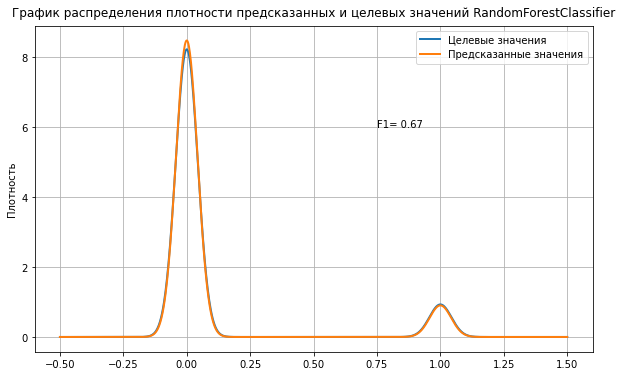

In [ ]:
graph_analis(y_valid, predict_rfc,'RandomForestClassifier')

### LogisticRegression

In [ ]:
model_lr = LogisticRegression(random_state=12345, solver='sag', class_weight='balanced', C = 5)
model_lr.fit(x_train_sw,target_sampled) 
predict_lr = model_lr.predict(x_valid_sw) 
result_lr = f1_score(y_valid, predict_lr)
print('Значение f1_score для модели LogisticRegression -', result_lr)

Значение f1_score для модели LogisticRegression - 0.7474198804997284


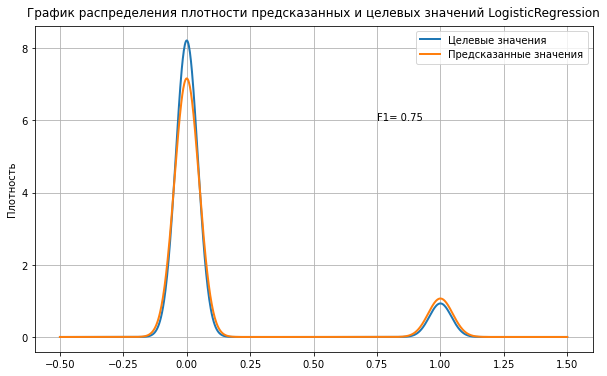

In [ ]:
graph_analis(y_valid, predict_lr,'LogisticRegression')

In [ ]:
# вычислим вероятность  классов
probabilities_valid = model_lr.predict_proba(x_valid_sw)
probabilities_one_valid = probabilities_valid[:, 1]

In [ ]:
# изменим порог
for threshold in np.arange(0.48, 0.88, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(y_valid,predicted_valid) 
    recall = recall_score(y_valid,predicted_valid) 
    f1 = f1_score(y_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))


Порог = 0.48 | Точность = 0.657, Полнота = 0.859, F1 = 0.745
Порог = 0.50 | Точность = 0.667, Полнота = 0.850, F1 = 0.747
Порог = 0.52 | Точность = 0.678, Полнота = 0.844, F1 = 0.752
Порог = 0.54 | Точность = 0.687, Полнота = 0.838, F1 = 0.755
Порог = 0.56 | Точность = 0.698, Полнота = 0.833, F1 = 0.759
Порог = 0.58 | Точность = 0.707, Полнота = 0.827, F1 = 0.763
Порог = 0.60 | Точность = 0.716, Полнота = 0.817, F1 = 0.763
Порог = 0.62 | Точность = 0.725, Полнота = 0.811, F1 = 0.766
Порог = 0.64 | Точность = 0.736, Полнота = 0.805, F1 = 0.769
Порог = 0.66 | Точность = 0.747, Полнота = 0.798, F1 = 0.772
Порог = 0.68 | Точность = 0.759, Полнота = 0.792, F1 = 0.775
Порог = 0.70 | Точность = 0.766, Полнота = 0.786, F1 = 0.776
Порог = 0.72 | Точность = 0.773, Полнота = 0.777, F1 = 0.775
Порог = 0.74 | Точность = 0.781, Полнота = 0.769, F1 = 0.775
Порог = 0.76 | Точность = 0.792, Полнота = 0.758, F1 = 0.775
Порог = 0.78 | Точность = 0.803, Полнота = 0.746, F1 = 0.773
Порог = 0.80 | Точность 

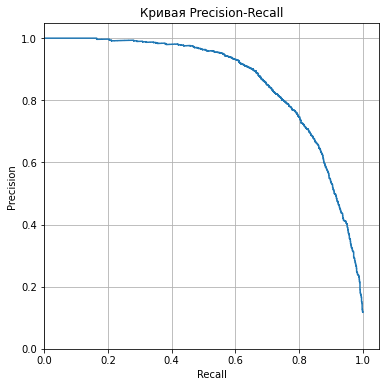

In [ ]:
# построим precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Кривая Precision-Recall')
plt.grid()
plt.show()


Кривая находится высоко - это хороший результат

In [ ]:
# наилучшее значение при пороге 0.7 - применяем на тестовой выборке
predicted_test = (model_lr.predict_proba(x_test_sw)[:,1]>0.7)*1
f1_lr = f1_score(y_test, predicted_test)
print('F1 score для модели Логистической регрессии с порогом 0.7 на тестовой выборке =', f1_lr.round(2))

F1 score для модели Логистической регрессии с порогом 0.7 на тестовой выборке = 0.78


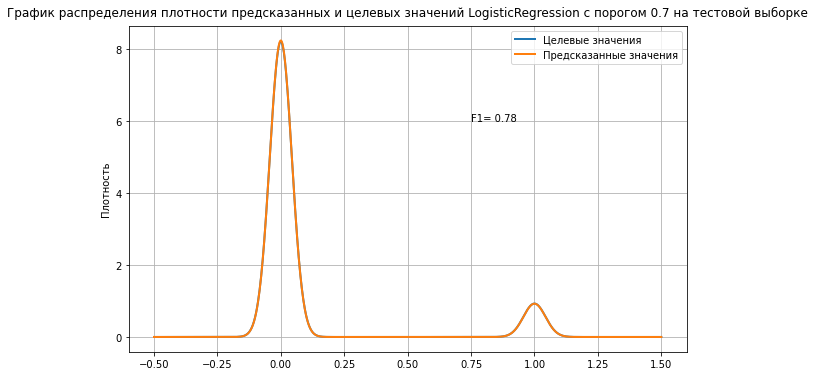

In [ ]:
graph_analis(y_test, predicted_test,'LogisticRegression с порогом 0.7 на тестовой выборке')

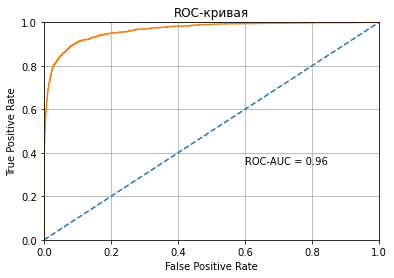

In [ ]:
# ROC-кривая
probabilities_test = model_lr.predict_proba(x_test_sw)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(y_test, probabilities_one_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC-кривая") 
plt.grid()
plt.text(0.6, 0.35, 'ROC-AUC = {:.2f}'.format(roc_auc))
plt.show()


Значение площади под кривой 0.96 - это крайне высокая вероятность, что модели удастся определить верный класс


## Выводы


Таким образом, для обучения текста на поиск токсичных коментариев мы сначала подготовили данные - очистили от лишних символов и стоп-слов, привели к начальной форме (лемматизировали), избавились от дисбаланса классов, чтобы модель обучилась корректно. Затем были применены три модели для обучения. Основной метрикой качества служила *F1*, которая должна быть не меньше 0.75.

**Результаты применения моделей:**

1. DecisionTreeClassifier = 0.62

2. RandomForestClassifier = 0.67

3. LogisticRegression = 0.75

Однако после изменения порога на 0.7 модель **LogisticRegression** улучшила свои предсказания и значение качество увеличилось до **0.78**. Что выполняет условия проекта. ROC - кривая также показала довольный высокий результат того, что предсказания не являются случайными.
